# Kitchenware Image Classification


## Inspect the data

In [3]:
import os

# Walk through kitchenware-dataset directory and list number of file
for path, dirs, files in os.walk('/kaggle/input/kitchenware-dataset/kitchenware-dataset'):
    print(f"There are {len(dirs)} directories and {len(files)} images in '{path}'.")

There are 3 directories and 0 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset'.
There are 0 directories and 6 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/eval-images'.
There are 6 directories and 0 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test'.
There are 0 directories and 499 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/glass'.
There are 0 directories and 660 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/spoon'.
There are 0 directories and 897 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/cup'.
There are 0 directories and 375 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/fork'.
There are 0 directories and 752 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/plate'.
There are 0 directories and 625 images in '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test/knife'.
There are 6 directories and 0 image

In [4]:
# Create train and test directories path
train_dir = '/kaggle/input/kitchenware-dataset/kitchenware-dataset/train'
test_dir = '/kaggle/input/kitchenware-dataset/kitchenware-dataset/test'

In [5]:
# Get the class names for kitchenware dataset
import numpy as np
from pathlib import Path

class_dir = Path(train_dir)
class_names = np.array(sorted([item.name for item in class_dir.glob('*')]))
print(class_names)

['cup' 'fork' 'glass' 'knife' 'plate' 'spoon']


In [6]:
# Get the images distribution in each class in train directory
for i in class_names:
    print(f"Training {i} images are {len(os.listdir(train_dir+'/'+i+'/'))}")

Training cup images are 1136
Training fork images are 557
Training glass images are 743
Training knife images are 909
Training plate images are 1227
Training spoon images are 989


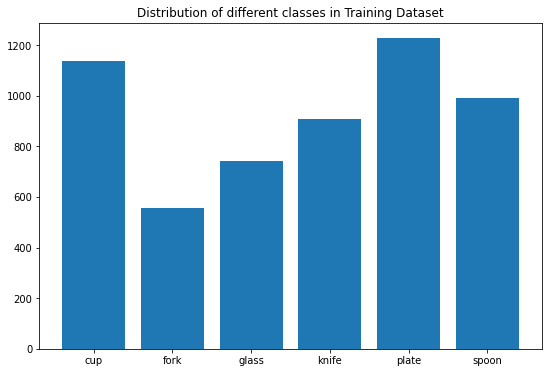

In [7]:
import matplotlib.pyplot as plt

# Count images in each class directory (train)
num_imgs = {}
for i in class_names:
  images_count = len(os.listdir(train_dir+'/'+i+'/'))
  num_imgs[i] = images_count

# Plot distribution
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(num_imgs)), list(num_imgs.values()), align='center')
plt.xticks(np.arange(len(num_imgs)), list(num_imgs.keys()))
plt.title('Distribution of different classes in Training Dataset')

plt.show()

In [8]:
# Get the images distribution in each class in test directory
for i in class_names:
  print(f"Test {i} images are {len(os.listdir(test_dir+'/'+i+'/'))}")

Test cup images are 897
Test fork images are 375
Test glass images are 499
Test knife images are 625
Test plate images are 752
Test spoon images are 660


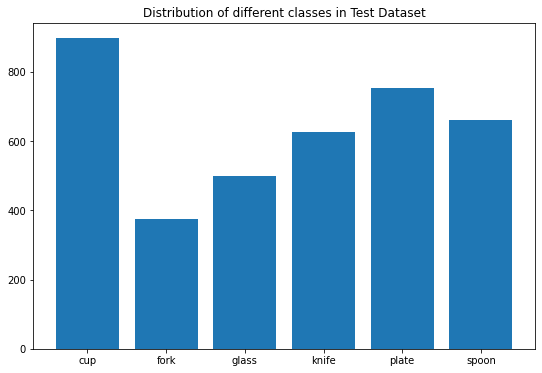

In [9]:
# Count images in each class directory (test)
num_imgs = {}
for i in class_names:
  images_count = len(os.listdir(test_dir+'/'+i+'/'))
  num_imgs[i] = images_count

# Plot distribution
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(num_imgs)), list(num_imgs.values()), align='center')
plt.xticks(np.arange(len(num_imgs)), list(num_imgs.keys()))
plt.title('Distribution of different classes in Test Dataset')

plt.show()

In [10]:
import random
import matplotlib.image as mpimg

# Function to display random image
def plot_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + '/' + target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0] # reads from list of images and randomly sample them
  
  # Read in the image and plot it using matplotlib
  filename = target_folder + '/' + random_image # return an image file name
  img = mpimg.imread(filename)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  return img

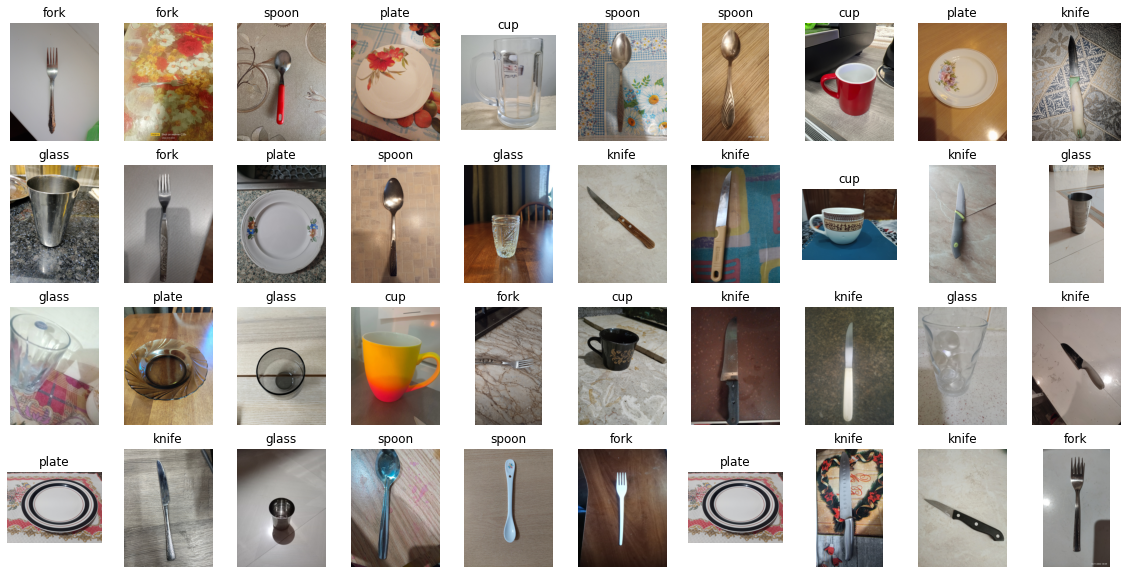

In [11]:
# Visualize random images from all 6 classes
fig = plt.figure(figsize=(20,10))
rows = 4
cols = 10
for i in np.arange(1, rows*cols+1):
  fig.add_subplot(rows, cols, i)
  img = plot_random_image(target_dir=train_dir,
                          target_class=random.choice(class_names))

## Creating data loaders (preparing the data)

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Train data (20% data for validation)
train_datagen = ImageDataGenerator(validation_split=0.2)
# Import train data from directory and turn it into batches
train_ds = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

# Validation data
val_ds = train_datagen.flow_from_directory(directory=train_dir,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          class_mode='categorical',
                                          subset='validation',
                                          shuffle=True,
                                          seed=42)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.
Found 3802 images belonging to 6 classes.


## Creating baseline model

In [13]:
# Build base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze the convolutional base by preventing the weights being updated during training
base_model.trainable = False

# Define expected image shape as input
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
# Feed inputs to the base model
base = base_model(inputs, training=False) # set False because the model contains BatchNormalization layer
# Convert matrices into feature vectors using pooling layer
vectors = tf.keras.layers.GlobalAveragePooling2D()(base)
# Create dense layer of 6 classes
outputs = tf.keras.layers.Dense(6, activation='softmax')(vectors)

# Create model for training
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

2022-12-14 19:53:17.395428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 19:53:17.554930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 19:53:17.555752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 19:53:17.557468: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


In [14]:
# Train model for 10 epochs
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

2022-12-14 19:53:23.528148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-14 19:53:29.521050: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


140/140 [==============================] - 101s 642ms/step - loss: 0.4008 - accuracy: 0.8876 - val_loss: 0.1878 - val_accuracy: 0.9387
Epoch 2/10
140/140 [==============================] - 72s 511ms/step - loss: 0.1535 - accuracy: 0.9560 - val_loss: 0.1489 - val_accuracy: 0.9504
Epoch 3/10
140/140 [==============================] - 71s 505ms/step - loss: 0.1200 - accuracy: 0.9663 - val_loss: 0.1335 - val_accuracy: 0.9540
Epoch 4/10
140/140 [==============================] - 71s 507ms/step - loss: 0.1006 - accuracy: 0.9739 - val_loss: 0.1258 - val_accuracy: 0.9549
Epoch 5/10
140/140 [==============================] - 72s 514ms/step - loss: 0.0887 - accuracy: 0.9771 - val_loss: 0.1205 - val_accuracy: 0.9567
Epoch 6/10
140/140 [==============================] - 71s 508ms/step - loss: 0.0786 - accuracy: 0.9789 - val_loss: 0.1176 - val_accuracy: 0.9594
Epoch 7/10
140/140 [==============================] - 71s 507ms/step - loss: 0.0701 - accuracy: 0.9838 - val_loss: 0.1160 - val_accuracy: 0.

In [15]:
# Evaluate the model on whole validation data
model.evaluate(val_ds)

35/35 [==============================] - 15s 415ms/step - loss: 0.1132 - accuracy: 0.9603


[0.11315853893756866, 0.9603246450424194]

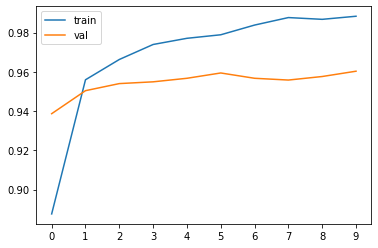

In [16]:
# Plot histroy of train and validation accuracy
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.xticks(range(len(hist['accuracy'])))
plt.legend()

plt.show()

## Create data augmentation layer

In [17]:
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
# Create a data augmentation layer with crop, horizontal and vertical flip, rotation,
# zoom, height, and width
aug_layer = tf.keras.Sequential([preprocessing.RandomFlip('horizontal'),
                                 preprocessing.RandomFlip('vertical'),
                                 preprocessing.RandomRotation(0.2),
                                 preprocessing.RandomZoom(0.2),
                                 preprocessing.RandomHeight(0.2),
                                 preprocessing.RandomWidth(0.2)])

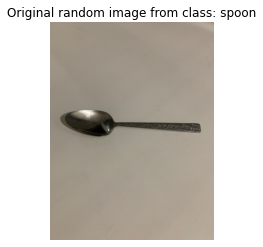

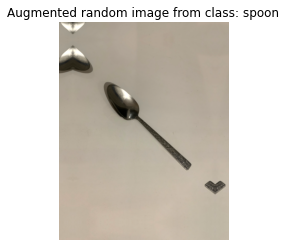

In [19]:
target_class = random.choice(class_names)  # choose a random class
target_dir = train_dir + '/' + target_class  # create the target directory
random_image = random.choice(os.listdir(target_dir))  # choose a random image from target directory
random_image_path = target_dir + '/' + random_image  # create the choosen random image path

# read in the chosen target image
img = mpimg.imread(random_image_path)
plt.imshow(img)  # plot the target image
plt.title(f'Original random image from class: {target_class}')
plt.axis('off');  # turn off the axes

# Augment the image
augmented_img = aug_layer(img)
plt.figure()
plt.imshow(augmented_img/225.)  # requires normalization after augmentation
plt.title(f'Augmented random image from class: {target_class}')
plt.axis('off')

plt.show()

## Finding optimal set of hyperparameters

In [20]:
# Install Keras Tuner library
!pip install -q -U keras-tuner

In [21]:
# Function to define the model
def model_builder(hp):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # Choose to add augmentation layer
    if hp.Choice('aug_layer', [True, False]) == True:
        x = aug_layer(inputs)
        x = base_model(x, training=False)
    else:
        x = base_model(inputs, training=False)
        
    # Choose the global pooling layer (max or avg)
    if hp.Choice('global_pooling', ['max', 'avg']) == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = tf.keras.layers.Dense(hp_units, activation='relu')(x)
  
    # Tune the droprate in the Dropout layer
    # Choose an optimal value between 0-0.5
    hp_dropout = hp.Float('dropout_rate', 0, 0.5, step=0.1)
    x = tf.keras.layers.Dropout(hp_dropout)(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
  
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [22]:
import keras_tuner as kt

# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                      objective='val_accuracy',
                      max_epochs=10,
                      factor=3,
                      directory='keras_tuner_dir',
                      project_name='kitchenware-classification')

In [23]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the search
tuner.search(train_ds,
             epochs=50,
             validation_data=val_ds,
             callbacks=[early_stopping])

Trial 30 Complete [00h 12m 18s]
val_accuracy: 0.951307475566864

Best val_accuracy So Far: 0.9603246450424194
Total elapsed time: 02h 21m 06s


In [25]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete and following are the
optimal hyperparameters:

Augmentation layer (True or False) = {best_hps.get('aug_layer')}
Global pooling layer - {best_hps.get('global_pooling')}
Units in the first dense layer - {best_hps.get('units')}
Dropout rate - {best_hps.get('dropout_rate')}
Learning rate - {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete and following are the
optimal hyperparameters:

Augmentation layer (True or False) = 0
Global pooling layer - avg
Units in the first dense layer - 192
Dropout rate - 0.4
Learning rate - 0.001



## Finding the optimal number of epochs

In [26]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Epoch 1/50
140/140 [==============================] - 77s 517ms/step - loss: 0.2420 - accuracy: 0.9164 - val_loss: 0.1374 - val_accuracy: 0.9504
Epoch 2/50
140/140 [==============================] - 71s 504ms/step - loss: 0.1107 - accuracy: 0.9629 - val_loss: 0.1340 - val_accuracy: 0.9486
Epoch 3/50
140/140 [==============================] - 70s 504ms/step - loss: 0.0780 - accuracy: 0.9733 - val_loss: 0.1319 - val_accuracy: 0.9513
Epoch 4/50
140/140 [==============================] - 70s 504ms/step - loss: 0.0640 - accuracy: 0.9804 - val_loss: 0.1246 - val_accuracy: 0.9594
Epoch 5/50
140/140 [==============================] - 71s 506ms/step - loss: 0.0571 - accuracy: 0.9813 - val_loss: 0.1356 - val_accuracy: 0.9576
Epoch 6/50
140/140 [==============================] - 71s 506ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.1287 - val_accuracy: 0.9567
Epoch 7/50
140/140 [==============================] - 70s 504ms/step - loss: 0.0265 - accuracy: 0.9946 - val_loss: 0.1354 - val_ac

## Retrain the model with best hyperparameters

In [32]:
# Create checkpoint to save the model
filepath = './checkpoints_feature_extraction/efficientnetb0_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max')

In [46]:
# Re-instantiate the hypermodel and train it with the optimal
# number of epochs from above
hypermodel = tuner.hypermodel.build(best_hps)

# Refit the model
history = hypermodel.fit(train_ds,
                         epochs=best_epoch,
                         validation_data=val_ds,
                         callbacks=[checkpoint])

Epoch 1/41
140/140 [==============================] - 87s 579ms/step - loss: 0.2467 - accuracy: 0.9160 - val_loss: 0.1370 - val_accuracy: 0.9468


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/41
140/140 [==============================] - 79s 562ms/step - loss: 0.1069 - accuracy: 0.9631 - val_loss: 0.1143 - val_accuracy: 0.9594
Epoch 3/41
140/140 [==============================] - 80s 570ms/step - loss: 0.0790 - accuracy: 0.9762 - val_loss: 0.1151 - val_accuracy: 0.9576
Epoch 4/41
140/140 [==============================] - 78s 561ms/step - loss: 0.0554 - accuracy: 0.9840 - val_loss: 0.1264 - val_accuracy: 0.9585
Epoch 5/41
140/140 [==============================] - 79s 563ms/step - loss: 0.0426 - accuracy: 0.9872 - val_loss: 0.1135 - val_accuracy: 0.9612
Epoch 6/41
140/140 [==============================] - 78s 560ms/step - loss: 0.0370 - accuracy: 0.9912 - val_loss: 0.1199 - val_accuracy: 0.9576
Epoch 7/41
140/140 [==============================] - 80s 569ms/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 0.1364 - val_accuracy: 0.9558
Epoch 8/41
140/140 [==============================] - 79s 565ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.1341 - val_ac

In [47]:
# Evaluate on val_ds
hypermodel.evaluate(val_ds)

35/35 [==============================] - 15s 435ms/step - loss: 0.2376 - accuracy: 0.9549


[0.23761104047298431, 0.9549143314361572]

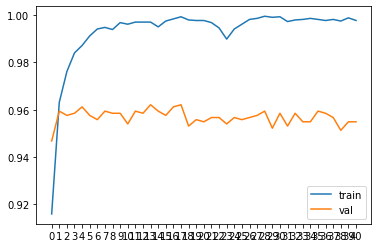

In [48]:
# Plot histroy of train and validation accuracy
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.xticks(range(len(hist['accuracy'])))
plt.legend()

plt.show()

## Fine-tune the hypermodel

In [40]:
# Check the layers in the hypermodel
hypermodel.layers

In [49]:
# Check which layers are trainable in hypermodel
for layer in hypermodel.layers:
    print(layer.name, layer.trainable)

input_8 True
efficientnetb0 False
global_average_pooling2d_3 True
dense_6 True
dropout_3 True
dense_7 True


In [50]:
print(f'Number of layers in the base model: {len(hypermodel.layers[1].layers)}')

Number of layers in the base model: 237


In [51]:
# Unfreeze the entire base model of hypermodel
hypermodel.layers[1].trainable = True

# Freeze all layers except for the last 50
for layer in hypermodel.layers[1].layers[:-50]:
    layer.trainable = False

In [52]:
# Recompile the model
hypermodel.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')/10), # lr is 10x lower than before for fine-tuning
                   metrics=["accuracy"])

In [53]:
# New checkpoint to save the model
filepath = './checkpoints_fine_tune/efficientnetb0_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max')

In [55]:
# Continue training the hypermodel
total_epochs = best_epoch + 10

history_fine = hypermodel.fit(train_ds,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=val_ds,
                              callbacks=[checkpoint])

Epoch 41/51
140/140 [==============================] - 84s 559ms/step - loss: 0.0308 - accuracy: 0.9935 - val_loss: 0.1939 - val_accuracy: 0.9576
Epoch 42/51
140/140 [==============================] - 78s 558ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.1986 - val_accuracy: 0.9621
Epoch 43/51
140/140 [==============================] - 77s 552ms/step - loss: 0.0121 - accuracy: 0.9955 - val_loss: 0.2256 - val_accuracy: 0.9621
Epoch 44/51
140/140 [==============================] - 77s 549ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 0.2159 - val_accuracy: 0.9576
Epoch 45/51
140/140 [==============================] - 76s 546ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.1873 - val_accuracy: 0.9567
Epoch 46/51
140/140 [==============================] - 78s 555ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.2170 - val_accuracy: 0.9558
Epoch 47/51
140/140 [==============================] - 76s 543ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.2054 -

In [56]:
# Evaluate the model
hypermodel.evaluate(val_ds)

35/35 [==============================] - 15s 430ms/step - loss: 0.2281 - accuracy: 0.9603


[0.22810141742229462, 0.9603246450424194]

In [74]:
def compare_histories(original_history, new_history, initial_epochs=best_epoch):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    val_acc = original_history.history["val_accuracy"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]

    # Make plots
    plt.figure(figsize=(8, 4))
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()

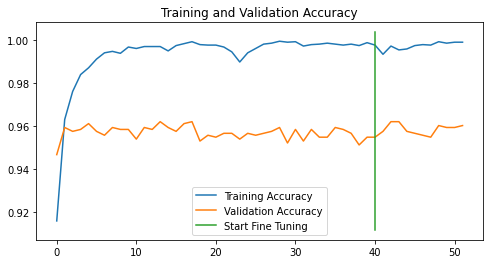

In [75]:
compare_histories(original_history=history,
                  new_history=history_fine)

## Load the best model for evaluation

In [77]:
# List of best models before fine-tuning
!ls /kaggle/working/checkpoints_feature_extraction

efficientnetb0_01_0.947.h5  efficientnetb0_05_0.961.h5
efficientnetb0_02_0.959.h5  efficientnetb0_14_0.962.h5


In [76]:
# List of best models after fine-tuning
!ls /kaggle/working/checkpoints_fine_tune

efficientnetb0_41_0.958.h5  efficientnetb0_42_0.962.h5


In [83]:
# Copy the best model in the parent directory to download
!cp /kaggle/working/checkpoints_feature_extraction/efficientnetb0_14_0.962.h5 /kaggle/working/